📥 Téléchargement du dataset GoEmotions...

📊 Total GoEmotions fusionné : 54,263 lignes

🔍 Re-classification en cours...



100%|██████████| 54263/54263 [00:00<00:00, 431725.87it/s]


📊 Après filtre neutral :
label
positive    17489
negative    16456
Name: count, dtype: int64

⚖️ Équilibrage des classes (undersampling)…

📊 Répartition équilibrée :
label
negative    16456
positive    16456
Name: count, dtype: int64



/tmp/ipykernel_13348/1988318893.py:78: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=min_size, random_state=42))



📐 SIZES:
Train      : 23,696
Validation : 2,633
Test       : 6,583

=== TRAIN (3 exemples) ===

📝 Texte : you having a bad day man
🏷️ Label : 0

📝 Texte : it s just nonsense any truly responsible gun owner respects life more than being tough
🏷️ Label : 0

📝 Texte : name some of these post i read on this sub its just getting too ridiculous
🏷️ Label : 0

=== VALIDATION (3 exemples) ===

📝 Texte : thanks you re right i should delete the app
🏷️ Label : 1

📝 Texte : i just saw it on there pretty cheap to be such a old item starting bid on one was a 1
🏷️ Label : 1

📝 Texte : i m confused what you re crying about the situation has very little to do with us
🏷️ Label : 0

=== TEST (3 exemples) ===

📝 Texte : as a household we deal with it by respecting each other s choices and opinions
🏷️ Label : 1

📝 Texte : every time she was in trouble i was there for her the man who caused most of her troubles
🏷️ Label : 0

📝 Texte : hell yeah i got the 420 upvote
🏷️ Label : 0


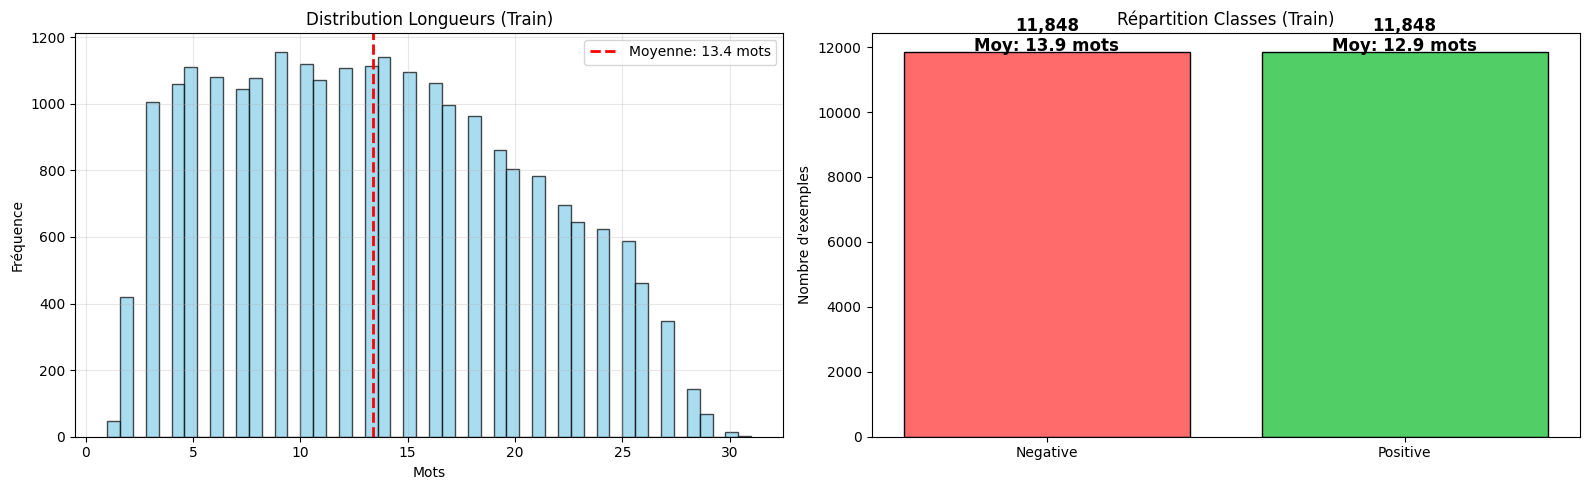

In [7]:
# ======================================================================
# 🎭 1. Chargement COMPLET du dataset GoEmotions
# ======================================================================

from datasets import load_dataset
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

print("📥 Téléchargement du dataset GoEmotions...\n")
dataset = load_dataset("go_emotions")

# ➤ Fusionner train + validation + test en un seul DataFrame
full_df = pd.concat([
    pd.DataFrame(dataset["train"]),
    pd.DataFrame(dataset["validation"]),
    pd.DataFrame(dataset["test"])
]).reset_index(drop=True)

print(f"📊 Total GoEmotions fusionné : {len(full_df):,} lignes")


# ======================================================================
# 🎨 2. Reclassification en POSITIVE / NEGATIVE + exclusion NEUTRAL
# ======================================================================

emotion_groups = {
    "joy": "positive", "amusement": "positive", "approval": "positive",
    "gratitude": "positive", "love": "positive", "pride": "positive",
    "relief": "positive", "admiration": "positive", "desire": "positive",

    "anger": "negative", "annoyance": "negative", "disgust": "negative",
    "disappointment": "negative", "disapproval": "negative",
}

neutral_labels = ["neutral", "realization", "surprise"]

id2label = dataset["train"].features["labels"].feature.names

texts, labels = [], []

print("\n🔍 Re-classification en cours...\n")

for row in tqdm(full_df.itertuples(), total=len(full_df)):
    emotion_list = [id2label[e] for e in row.labels]

    # 1) Si NEUTRAL : on exclut complètement la ligne
    if any(em in neutral_labels for em in emotion_list):
        continue

    # 2) POSITIVE si au moins une émotion positive
    is_positive = any(em in emotion_groups and emotion_groups[em] == "positive"
                      for em in emotion_list)

    label = "positive" if is_positive else "negative"

    texts.append(row.text)
    labels.append(label)

# DataFrame final
df = pd.DataFrame({"text": texts, "label": labels})

print("\n📊 Après filtre neutral :")
print(df["label"].value_counts())


# ======================================================================
# ⚖️ 3. Équilibrage POSITIVE / NEGATIVE
# ======================================================================

print("\n⚖️ Équilibrage des classes (undersampling)…")
min_size = df["label"].value_counts().min()

df_balanced = (
    df.groupby("label", group_keys=False)
      .apply(lambda x: x.sample(n=min_size, random_state=42))
      .reset_index(drop=True)
)

print("\n📊 Répartition équilibrée :")
print(df_balanced["label"].value_counts())


# ======================================================================
# 🧹 4. Nettoyage du texte (adapté Whisper)
# ======================================================================

import re
import string

def clean_text_whisper(text: str) -> str:
    text = text.lower()
    text = re.sub(r"http\S+", " ", text)            # URLs
    text = re.sub(f"[{string.punctuation}]", " ", text)  # ponctuation
    text = re.sub(r"[^\w\s]", " ", text)           # emojis et caractères spéciaux
    text = re.sub(r"\s+", " ", text).strip()       # espaces multiples
    return text

df_balanced["text"] = df_balanced["text"].apply(clean_text_whisper)

# ➤ Encodage binaire (important pour train/test split)
df_balanced["label_bin"] = df_balanced["label"].map({"negative": 0, "positive": 1})


# ======================================================================
# ✂️ 5. Split Train / Validation / Test
# ======================================================================

from sklearn.model_selection import train_test_split

# 1) Train / Test
X_train, X_test, y_train, y_test = train_test_split(
    df_balanced["text"],
    df_balanced["label_bin"],
    test_size=0.20,
    random_state=42,
    stratify=df_balanced["label_bin"]
)

# 2) Split du train → Validation
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.10,
    random_state=42,
    stratify=y_train
)

print("\n📐 SIZES:")
print(f"Train      : {len(X_train):,}")
print(f"Validation : {len(X_val):,}")
print(f"Test       : {len(X_test):,}")


# ======================================================================
# 📝 6. Écriture CSV (optionnel pour Docker)
# ======================================================================

X_train.to_csv("train_texts.csv", index=False, header=True)
pd.DataFrame(y_train).to_csv("train_labels.csv", index=False, header=True)
X_val.to_csv("val_texts.csv", index=False, header=True)
pd.DataFrame(y_val).to_csv("val_labels.csv", index=False, header=True)
X_test.to_csv("test_texts.csv", index=False, header=True)
pd.DataFrame(y_test).to_csv("test_labels.csv", index=False, header=True)


# ======================================================================
# 👀 7. Exemples de données
# ======================================================================

import random

def show_examples(X, y, name, n=3):
    print(f"\n=== {name.upper()} ({n} exemples) ===")
    idx = random.sample(range(len(X)), n)
    for i in idx:
        print(f"\n📝 Texte : {X.iloc[i]}")
        print(f"🏷️ Label : {y.iloc[i]}")

show_examples(X_train, y_train, "train", 3)
show_examples(X_val, y_val, "validation", 3)
show_examples(X_test, y_test, "test", 3)


# ======================================================================
# 📊 8. Visualisations
# ======================================================================

train_lengths = X_train.apply(lambda x: len(x.split()))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# -----------------------------
# 1) Distribution longueurs
# -----------------------------
ax1.hist(train_lengths, bins=50, edgecolor='black', color='skyblue', alpha=0.7)
mean_len = np.mean(train_lengths)
ax1.axvline(mean_len, color='red', linestyle='--', linewidth=2,
            label=f'Moyenne: {mean_len:.1f} mots')
ax1.set_title("Distribution Longueurs (Train)")
ax1.set_xlabel("Mots")
ax1.set_ylabel("Fréquence")
ax1.legend()
ax1.grid(alpha=0.3)

# -----------------------------
# 2) Répartition classes avec count exact + moyenne mots
# -----------------------------
labels_names = ["Negative", "Positive"]
counts = [np.sum(y_train == 0), np.sum(y_train == 1)]
colors = ['#ff6b6b', '#51cf66']

ax2.bar(labels_names, counts, color=colors, edgecolor="black")
ax2.set_title("Répartition Classes (Train)")
ax2.set_ylabel("Nombre d'exemples")

# Ajouter count exact + moyenne de mots au-dessus de chaque barre
for i, count in enumerate(counts):
    mean_words = np.mean([len(text.split()) for text, label in zip(X_train, y_train) if label == i])
    ax2.text(i, count + 20, f'{count:,}\nMoy: {mean_words:.1f} mots', 
             ha='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()


In [8]:
# ======================================================================
# 💾 8. Sauvegarde des splits en CSV
# ======================================================================

train_df = pd.DataFrame({"text": X_train, "label": y_train})
val_df   = pd.DataFrame({"text": X_val, "label": y_val})
test_df  = pd.DataFrame({"text": X_test, "label": y_test})

# Chemin où tu veux sauvegarder
output_dir = "./data_splits"  # adapte si besoin
import os
os.makedirs(output_dir, exist_ok=True)

train_df.to_csv(f"{output_dir}/train.csv", index=False)
val_df.to_csv(f"{output_dir}/val.csv", index=False)
test_df.to_csv(f"{output_dir}/test.csv", index=False)

print(f"\n📁 CSV sauvegardés dans {output_dir}/")



📁 CSV sauvegardés dans ./data_splits/
